In [3]:
import numpy as np
import os
from numpy.random import randint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
#plt.rcParams["figure.figsize"] = [20,10]

In [4]:
def load_puzzle(puzzle_no):
    PUZZLE_DIR = "./puzzles/"
    
    cube = np.zeros((9, 9, 9))
    with open(os.path.join(PUZZLE_DIR, "{}.html".format(puzzle_no))) as reader:
        for line in reader:
            entry = map(int, line.strip().split(","))
            cube[entry[0], entry[1], entry[2]] = entry[3]
    return cube    

In [2]:
def check_perfect_square(num):
    root = round(num ** (1./2))
    return root**2 == num

check_perfect_square(3)

False

In [3]:
def create_cube(S):
    if not check_perfect_square(S):
        raise ValueError('S needs to be a perfect square')
    return np.zeros((S, S, S))


def random_init(cube, S, N):
    for _ in np.arange(N):
        cube[randint(0, S), randint(0,S), randint(0, S)] = randint(1, S + 1)
S = 4
cube = create_cube(S)
random_init(cube, S, 100)
print(cube)

[[[ 4.  3.  2.  4.]
  [ 3.  3.  3.  3.]
  [ 0.  3.  0.  1.]
  [ 1.  1.  4.  4.]]

 [[ 0.  0.  4.  4.]
  [ 3.  1.  3.  1.]
  [ 0.  4.  0.  1.]
  [ 4.  4.  1.  4.]]

 [[ 2.  1.  0.  3.]
  [ 0.  1.  0.  0.]
  [ 1.  3.  3.  3.]
  [ 4.  1.  2.  1.]]

 [[ 0.  1.  4.  0.]
  [ 3.  2.  4.  1.]
  [ 4.  2.  2.  3.]
  [ 1.  0.  0.  2.]]]


In [4]:
def slices(cube, orientation):
    S = cube.shape[0]
    if orientation not in {0, 1, 2}:
        raise ValueError("Invalid orientation")
    for index in range(S):
        if orientation == 0:
            yield cube[index, :, :]
        if orientation == 1:
            yield cube[:, index, :]
        if orientation == 2:
            yield cube[:, :, index]

next(slices(cube, 2))

array([[ 4.,  3.,  0.,  1.],
       [ 0.,  3.,  0.,  4.],
       [ 2.,  0.,  1.,  4.],
       [ 0.,  3.,  4.,  1.]])

In [1]:
def get_plot_cube(cube):
    S = cube.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlim3d(left=0, right=S-0.75)
    ax.set_ylim3d(bottom=0, top=S-0.75)
    ax.set_zlim3d(bottom=0, top=S-0.75)
    
    return ax
def plot_cube(cube):
    ax = get_plot_cube(cube)
    S = cube.shape[0]
    for a in range(0, S):
        for b in range(0, S):
            for c in range(0, S):
                ax.text3D(x=a, y=b, z=c, s=int(cube[a, b, c]))
    plt.show()
plot_cube(cube)

NameError: name 'cube' is not defined

<IPython.core.display.Javascript object>


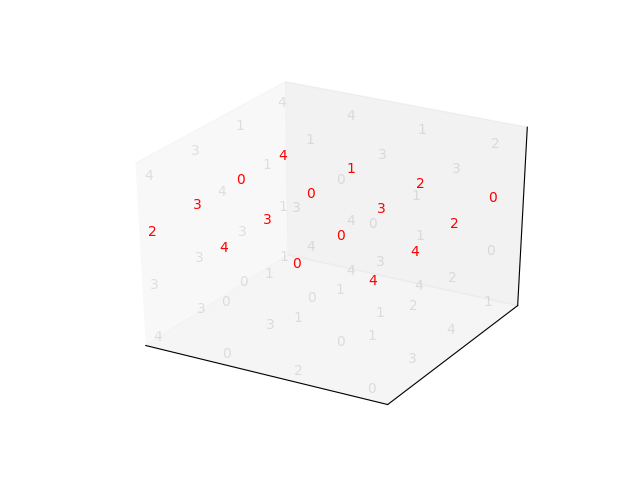

In [41]:
def plot_slice(cube, orientation, index, alpha=0.1):
    ax = get_plot_cube(cube)
    S = cube.shape[0]
    for a in range(0, S):
        for b in range(0, S):
            for c in range(0, S):
                if orientation == 0 and a == index:
                    ax.text3D(x=a, y=b, z=c, s=int(cube[a, b, c]), color="red")
                if orientation == 1 and b == index:ppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppppp
                    ax.text3D(x=a, y=b, z=c, s=int(cube[a, b, c]), color="red")
                if orientation == 2 and c == index:
                    ax.text3D(x=a, y=b, z=c, s=int(cube[a, b, c]), color="red")
                else:
                    ax.text3D(x=a, y=b, z=c, s=int(cube[a, b, c]), alpha=alpha)
plot_slice(cube, 2, 2)

<IPython.core.display.Javascript object>


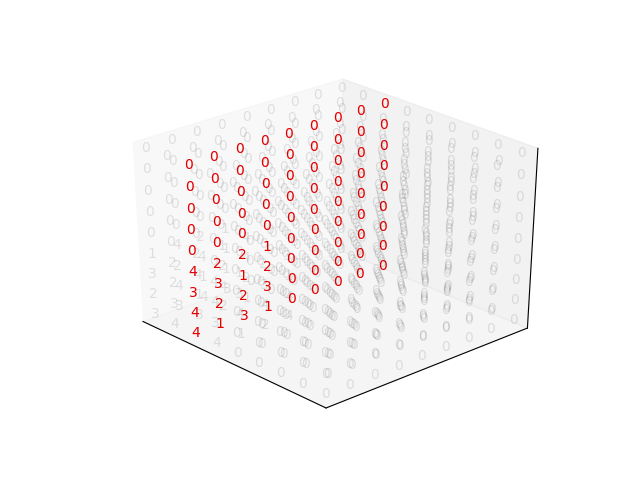

In [43]:
cube2 = create_cube(9)
random_init(cube2, S, 10000)

plot_slice(cube2, 0, 2)

# Example of a sudoku -> CNF 
Sourced from: https://github.com/ContinuumIO/pycosat/blob/master/examples/sudoku.py

Note taht this solves a 9x9 only. 

In [29]:
"""
The implementation of this Sudoku solver is based on the paper:

    "A SAT-based Sudoku solver" by Tjark Weber

    https://www.lri.fr/~conchon/mpri/weber.pdf

If you want to understand the code below, in particular the function valid(),
which calculates the 324 clauses corresponding to 9 cells, you are strongly
encouraged to read the paper first.  The paper is very short, but contains
all necessary information.
"""
import pycosat


def v(i, j, d):
    """
    Return the number of the variable of cell i, j and digit d,
    which is an integer in the range of 1 to 729 (including).
    """
    return 81 * (i - 1) + 9 * (j - 1) + d


def sudoku_clauses():
    """
    Create the (11745) Sudoku clauses, and return them as a list.
    Note that these clauses are *independent* of the particular
    Sudoku puzzle at hand.
    """
    res = []
    # for all cells, ensure that the each cell:
    for i in range(1, 10):
        for j in range(1, 10):
            # denotes (at least) one of the 9 digits (1 clause)
            res.append([v(i, j, d) for d in range(1, 10)])
            # does not denote two different digits at once (36 clauses)
            for d in range(1, 10):
                for dp in range(d + 1, 10):
                    res.append([-v(i, j, d), -v(i, j, dp)])

    def valid(cells):
        # Append 324 clauses, corresponding to 9 cells, to the result.
        # The 9 cells are represented by a list tuples.  The new clauses
        # ensure that the cells contain distinct values.
        for i, xi in enumerate(cells):
            for j, xj in enumerate(cells):
                if i < j:
                    for d in range(1, 10):
                        res.append([-v(xi[0], xi[1], d), -v(xj[0], xj[1], d)])

    # ensure rows and columns have distinct values
    for i in range(1, 10):
        valid([(i, j) for j in range(1, 10)])
        valid([(j, i) for j in range(1, 10)])
    # ensure 3x3 sub-grids "regions" have distinct values
    for i in 1, 4, 7:
        for j in 1, 4 ,7:
            valid([(i + k % 3, j + k // 3) for k in range(9)])

    assert len(res) == 81 * (1 + 36) + 27 * 324
    return res


def solve(grid):
    """
    solve a Sudoku grid inplace
    """
    clauses = sudoku_clauses()
    for i in range(1, 10):
        for j in range(1, 10):
            d = grid[i - 1][j - 1]
            # For each digit already known, a clause (with one literal).
            # Note:
            #     We could also remove all variables for the known cells
            #     altogether (which would be more efficient).  However, for
            #     the sake of simplicity, we decided not to do that.
            if d:
                clauses.append([v(i, j, d)])

    # solve the SAT problem
    sol = set(pycosat.solve(clauses, verbose=1))

    def read_cell(i, j):
        # return the digit of cell i, j according to the solution
        for d in range(1, 10):
            if v(i, j, d) in sol:
                return d

    for i in range(1, 10):
        for j in range(1, 10):
            grid[i - 1][j - 1] = read_cell(i, j)


if __name__ == '__main__':
    from pprint import pprint

    # hard Sudoku problem, see Fig. 3 in paper by Weber
    hard = [[0, 2, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 6, 0, 0, 0, 0, 3],
            [0, 7, 4, 0, 8, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 3, 0, 0, 2],
            [0, 8, 0, 0, 4, 0, 0, 1, 0],
            [6, 0, 0, 5, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 7, 8, 0],
            [5, 0, 0, 0, 0, 9, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 4, 0]]
    solve(hard)
    pprint(hard)
    assert [[1, 2, 6, 4, 3, 7, 9, 5, 8],
            [8, 9, 5, 6, 2, 1, 4, 7, 3],
            [3, 7, 4, 9, 8, 5, 1, 2, 6],
            [4, 5, 7, 1, 9, 3, 8, 6, 2],
            [9, 8, 3, 2, 4, 6, 5, 1, 7],
            [6, 1, 2, 5, 7, 8, 3, 9, 4],
            [2, 6, 9, 3, 1, 4, 7, 8, 5],
            [5, 4, 8, 7, 6, 9, 2, 3, 1],
            [7, 3, 1, 8, 5, 2, 6, 4, 9]] == hard

[[1, 2, 6, 4, 3, 7, 9, 5, 8],
 [8, 9, 5, 6, 2, 1, 4, 7, 3],
 [3, 7, 4, 9, 8, 5, 1, 2, 6],
 [4, 5, 7, 1, 9, 3, 8, 6, 2],
 [9, 8, 3, 2, 4, 6, 5, 1, 7],
 [6, 1, 2, 5, 7, 8, 3, 9, 4],
 [2, 6, 9, 3, 1, 4, 7, 8, 5],
 [5, 4, 8, 7, 6, 9, 2, 3, 1],
 [7, 3, 1, 8, 5, 2, 6, 4, 9]]


In [33]:
cnf = [[1, -5, 4], [-1, 5, 3, 4], [-3, -4]]
pycosat.solve(cnf, verbose=1)

[1, -2, -3, -4, 5]